In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

#FUNCIONES PROPIAS

In [2]:
def accuracy(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la accuracy.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  accuracy: float

  """
  tp = matriz_conf[0,0]
  tn = matriz_conf[1,1]
  fp = matriz_conf[1,0]
  fn = matriz_conf[0,1]
  return (tp+tn)/(tp+tn+fp+fn)

In [3]:
def recall(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve el recall.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  recall: float
  """
  tp = matriz_conf[0,0]
  fn = matriz_conf[0,1]
  return tp/(tp+fn)

In [4]:
def precision(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la precisión.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  precision: float
  """
  tp = matriz_conf[0,0]
  fp = matriz_conf[1,0]
  return tp/(tp+fp) if (tp + fp) > 0 else 0

In [5]:
def especifidad(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la especifidad.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  especifidad: float
  """
  tn = matriz_conf[1,1]
  fp = matriz_conf[1,0]
  return tn/(tn+fp)

In [6]:
def strat_hold_out_manual(datos:pd.DataFrame, target:str = "status", test_size:float = 0.2, random_state:int = 42):
  """
  Toma un dataframe y hace hold_out estratificado manualmente para clasificación binaria. Devuelve los datos de entrenamiento y prueba
  de características y objetivo.

  PARÁMETROS:
  - datos: Los datos en cuestión
  - target: El nombre de la columna objetivo
  - test_size: El tamaño de la prueba
  - random_state: Valor para replicabilidad

  RETURN
  - X_train: Características de entrenamiento
  - y_train: Objetivo de entrenamiento
  - X_test: Características de prueba
  - y_test: Objetivo de prueba
  """
  datos = datos.sample(frac=1, random_state=random_state).reset_index(drop=True)
  df_clase_1 = datos[datos[target] == 1]
  df_clase_0 = datos[datos[target] == 0]

  clase_0_entrenamiento, clase_0_prueba = train_test_split(df_clase_0, test_size=0.2, random_state=random_state)
  clase_1_entrenamiento, clase_1_prueba = train_test_split(df_clase_1, test_size=0.2, random_state=random_state)
  entrenamiento_comp = pd.concat([clase_0_entrenamiento,
                                clase_1_entrenamiento]).sample(frac=1, random_state=random_state).reset_index(drop=True)

  prueba_comp = pd.concat([clase_0_prueba, clase_1_prueba]).sample(frac=1, random_state=random_state).reset_index(drop=True)

  #Características:
  escalador = MinMaxScaler()
  X_train = escalador.fit_transform(entrenamiento_comp.drop(columns=[target]))
  y_train = entrenamiento_comp[target]
  #Target
  X_test = escalador.transform(prueba_comp.drop(columns=[target]))
  y_test = prueba_comp[target]
  return (X_train, y_train, X_test, y_test)

#SECCIÓN 1:
## Tratamiento de datos

In [7]:
datos= pd.read_csv('pd_speech_features.csv').astype(float).drop(columns=["id"])
datos.rename(columns={"class": "status"}, inplace=True)
datos.head(10)

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,status
0,1.0,0.85247,0.71826,0.57227,240.0,239.0,0.008064,0.000087,0.00218,0.000018,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1.0
1,1.0,0.76686,0.69481,0.53966,234.0,233.0,0.008258,0.000073,0.00195,0.000016,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1.0
2,1.0,0.85083,0.67604,0.58982,232.0,231.0,0.008340,0.000060,0.00176,0.000015,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1.0
3,0.0,0.41121,0.79672,0.59257,178.0,177.0,0.010858,0.000183,0.00419,0.000046,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1.0
4,0.0,0.32790,0.79782,0.53028,236.0,235.0,0.008162,0.002669,0.00535,0.000044,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1.0
5,0.0,0.50780,0.78744,0.65451,226.0,221.0,0.007631,0.002696,0.00783,0.000060,...,4.8025,5.0734,7.0166,5.9966,5.2065,7.4246,3.4153,3.5046,3.2250,1.0
6,1.0,0.76095,0.62145,0.54543,322.0,321.0,0.005991,0.000107,0.00222,0.000013,...,117.2678,75.3156,32.0478,7.7060,3.1060,4.6206,12.8353,13.8300,7.7693,1.0
7,1.0,0.83671,0.62079,0.51179,318.0,317.0,0.006074,0.000136,0.00282,0.000017,...,3.8564,11.8909,7.2891,4.3682,3.6443,5.9610,11.7552,18.0927,5.0448,1.0
8,1.0,0.80826,0.61766,0.50447,318.0,317.0,0.006057,0.000069,0.00161,0.000010,...,2.2640,6.3993,4.4165,4.2662,3.6357,3.7346,2.9394,3.6216,3.8430,1.0
9,0.0,0.85302,0.62247,0.54855,493.0,492.0,0.003910,0.000040,0.00075,0.000003,...,1.6796,2.0474,2.8117,3.5070,3.2727,3.8415,3.9439,5.8807,38.7211,1.0


In [8]:
#escalador = MinMaxScaler()
#datos = pd.DataFrame(escalador.fit_transform(datos_crudos.drop(columns = "status")), columns=datos_crudos.columns[:-1])
#datos["status"] = datos_crudos["status"].astype(int)
#datos.head(100)

status
1.0    564
0.0    192
Name: count, dtype: int64
----En proporción----
status
1.0    0.746032
0.0    0.253968
Name: proportion, dtype: float64


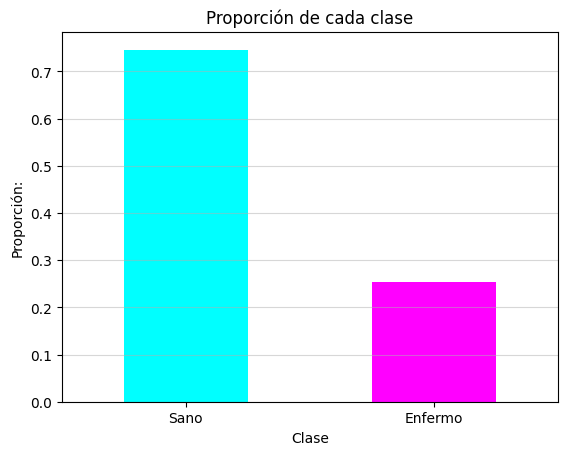

In [9]:
cantidades = datos["status"].value_counts(normalize = False)
proporciones = datos["status"].value_counts(normalize = True)
print(cantidades)
print("----En proporción----")
print(proporciones)
plt.title("Proporción de cada clase")
proporciones.plot(kind = "bar", color =["cyan", "magenta"])#, label = "Sano")
plt.xlabel("Clase")
plt.ylabel("Proporción:")
plt.xticks(np.arange(2), ["Sano", "Enfermo"], rotation = 0)
#plt.yticks(np.arange(0, 0.8, 0.05))
plt.grid(axis ="y", alpha = 0.5)
plt.show()

La proporción es 75% - 25% por lo que hay desbalanceo moderado

In [10]:
df = datos.astype(str)

# Fila que contiene al menos un "?" en alguna celda
df_con_interrogacion = df[df.apply(lambda fila: fila.str.contains(r"\?").any(), axis=1)]

# Fila que NO contiene ningún "?" en ninguna celda
df_sin_interrogacion = df[~df.apply(lambda fila: fila.str.contains(r"\?").any(), axis=1)]

print(f"Filas con '?': {len(df_con_interrogacion)}")
print(f"Filas sin '?': {len(df_sin_interrogacion)}")

Filas con '?': 0
Filas sin '?': 756


No hay '?'

In [11]:
#Generamos arrays para guardar las métricas de cada corrida y algorítmo de ML
accuracys = np.zeros((30, 5))
recalls = np.zeros((30, 5))
precisions = np.zeros((30, 5))
especificidades = np.zeros((30, 5))
for i in range(30):
  #GENERAR DAT. DE TRAIN Y TEST:

  X_train, y_train, X_test, y_test = strat_hold_out_manual(datos, random_state=i)


  #------MODELOS------#

  #MultiLayerPerceptron
  mlp = MLPClassifier(
    hidden_layer_sizes=(80, 60, 40),
    activation='relu',
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=i,
    verbose=False)
  #KNN
  knn_3 = KNeighborsClassifier(n_neighbors=3, metric = "euclidean")
  knn_5 = KNeighborsClassifier(n_neighbors=5, metric = "euclidean")
  knn_27 = KNeighborsClassifier(n_neighbors=27, metric = "euclidean")
  #Perceptron
  perceptron = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    learning_rate='adaptive',
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=i,
    verbose=False)
  modelos = [mlp, perceptron, knn_3, knn_5, knn_27]

  for j, modelo in enumerate(modelos):
    modelo.fit(X_train, y_train)
    y_test_pred = np.where(modelo.predict_proba(X_test)[:, 0] >= 0.1, 0, 1)
    matriz_conf = confusion_matrix(y_test, y_test_pred)
    accuracys[i, j] = accuracy(matriz_conf)
    recalls[i, j] = recall(matriz_conf)
    precisions[i, j] = precision(matriz_conf)
    especificidades[i, j] = especifidad(matriz_conf)

In [12]:
#mlp, perceptron, knn3, knn5, knn7
columnas = ["Accuracy", "Recall", "Precision", "Especificidad"]
tablas = []
for i in range(5):
  tabla_knn_27 = pd.DataFrame(np.array([accuracys[:, i], recalls[:, i], precisions[:, i],
                                   especificidades[:, i]]).T, columns = columnas, index = np.arange(1, 31))
  tabla_knn_27.index.name = "Corrida"
  tabla_knn_27.loc["Máx."] = tabla_knn_27.max()
  tabla_knn_27.loc["Mín."] = tabla_knn_27.min()
  tabla_knn_27.loc["Prom."] = tabla_knn_27.mean()
  tabla_knn_27.loc["Std."] = tabla_knn_27.std()
  tablas.append(tabla_knn_27)


In [13]:
print("-------------------------MLP-------------------------")
tablas[0].tail(10)

-------------------------MLP-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.736842,0.871795,0.492754,0.690265
26,0.493421,1.000000,0.336207,0.318584
27,0.473684,1.000000,0.327731,0.292035
28,0.835526,0.435897,0.850000,0.973451
29,0.302632,1.000000,0.268966,0.061947
30,0.559211,0.948718,0.362745,0.424779
Máx.,0.848684,1.000000,0.850000,0.973451
Mín.,0.282895,0.435897,0.263514,0.035398
Prom.,0.626439,0.854167,0.459383,0.547290


In [14]:
print("---------------------PERCEPTRON----------------------")
tablas[1].tail(10)

---------------------PERCEPTRON----------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.736842,0.923077,0.493151,0.672566
26,0.282895,1.000000,0.263514,0.035398
27,0.802632,0.666667,0.604651,0.849558
28,0.572368,0.923077,0.367347,0.451327
29,0.763158,0.794872,0.525424,0.752212
30,0.756579,0.846154,0.515625,0.725664
Máx.,0.842105,1.000000,0.727273,0.920354
Mín.,0.282895,0.615385,0.263514,0.035398
Prom.,0.648849,0.876603,0.450121,0.570243


In [15]:
print("------------------------KNN3-------------------------")
tablas[2].tail(10)

------------------------KNN3-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.855263,1.000000,0.639344,0.805310
26,0.815789,0.974359,0.584615,0.761062
27,0.802632,0.974359,0.567164,0.743363
28,0.868421,0.897436,0.686275,0.858407
29,0.881579,1.000000,0.684211,0.840708
30,0.815789,0.923077,0.590164,0.778761
Máx.,0.881579,1.000000,0.686275,0.858407
Mín.,0.782895,0.897436,0.545455,0.734513
Prom.,0.832031,0.951122,0.613022,0.791206


In [16]:
print("------------------------KNN5-------------------------")
tablas[3].tail(10)

------------------------KNN5-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.756579,1.000000,0.513158,0.672566
26,0.710526,1.000000,0.469880,0.610619
27,0.690789,1.000000,0.453488,0.584071
28,0.763158,0.948718,0.521127,0.699115
29,0.769737,1.000000,0.527027,0.690265
30,0.756579,0.948718,0.513889,0.690265
Máx.,0.782895,1.000000,0.542857,0.716814
Mín.,0.684211,0.923077,0.448276,0.575221
Prom.,0.734581,0.979968,0.492646,0.649336


In [17]:
print("-----------------------KNN27-------------------------")
tablas[4].tail(10)

-----------------------KNN27-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.519737,1.000000,0.348214,0.353982
26,0.500000,1.000000,0.339130,0.327434
27,0.539474,1.000000,0.357798,0.380531
28,0.539474,1.000000,0.357798,0.380531
29,0.605263,1.000000,0.393939,0.469027
30,0.513158,1.000000,0.345133,0.345133
Máx.,0.605263,1.000000,0.393939,0.469027
Mín.,0.453947,0.923077,0.319672,0.265487
Prom.,0.531661,0.991186,0.354325,0.372235


In [18]:
nombres = ["MLP", "Perceptron", "KNN3", "KNN5", "KNN27"]
from google.colab import files
for i in range(5):
  nombre_archivo = f"ds2_{nombres[i]}_sho.csv"
  tablas[i].to_csv(nombre_archivo)
  files.download(nombre_archivo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>